In [1]:
import torch

In [2]:
def custom_compare(x, y):
    if str(x) != str(y):
        raise RuntimeError(f'Ожидаемое значение: {y}. Фактическое: {x}')

In [3]:
def to_list(x, precision=2):
    return [round(x, precision) for x in x.flatten().tolist()]

In [4]:
def to_list_m(m, precision=2):
    res = []
    
    for l in m.tolist():
        res.append([round(x, precision) for x in l])
        
    return res

# Современные архитектуры свёрточных сетей

In [5]:
from torch.nn import Module, Sequential, Conv2d, MaxPool2d
from torch import cat

def set_seed():
    import random
    import numpy as np
    import torch
    
    SEED = 0

    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

In [6]:
class InceptionBlock(Module):
    def __init__(self, c_in, c_1, c_2, c_3):
        # Необходимый для проверки корректности работы inception-блока код.
        set_seed()
        
        super().__init__()
        
        # TODO: Свёртка C1 размера 1x1.
        self.c1 = Conv2d(c_in,c_1,1)
        
        # TODO: Свёртка C5 размера 1x1.
        self.c5 = Conv2d(c_in,c_1,1)
        # TODO: Свёртка C2 размера 3x3. Параметр padding = 1.
        self.c2 = Conv2d(c_1,c_2,3,padding=1)
        
        # TODO: Свёртка C6 размера 1x1.
        self.c6 = Conv2d(c_in,c_1,1)
        # TODO: Свёртка C3 размера 5x5. Параметр padding = 2.
        self.c3 = Conv2d(c_1,c_3,5,padding=2)
        
        # TODO: MaxPooling 2D MP1 размера 3x3. Параметры stride = 1, padding = 1.
        self.mp1 = MaxPool2d(kernel_size=3,stride=1,padding=1)
        # TODO: Свёртка C4 размера 1x1.
        self.c4 = Conv2d(c_in,c_1,1)
        
        
        # Полная ветка блока со свёрткой 3x3.
        self.block_3_3 = Sequential(
            self.c5,
            self.c2,
        )
        
        # Полная ветка блока со свёрткой 5x5.
        self.block_5_5 = Sequential(
            self.c6,
            self.c3,
        )
        
        # Полная ветка блока с MaxPooling 2D.
        self.block_pool = Sequential(
            self.mp1,
            self.c4,
        )
    
    def forward(self, x):
        # В качестве результата работы inception-блок возвращает
        # соединение по размерности каналов результатов работы внутренних
        # свёрток и MaxPooling 2D.
        return cat([
            self.c1(x),
            self.block_3_3(x),
            self.block_5_5(x),
            self.block_pool(x),
        ], dim=1)

In [7]:
def inception_block_test():
    example_1_x = torch.tensor([[[[0.28, 0.48], 
                                  [0.82, 1.0]]
                                ]])
    example_1_res = [-0.83, -0.83, -0.83, -0.83, -0.59, -0.48, -0.3, -0.2, 0.35, 0.69, 0.27, 0.58, -0.14, -0.15, -0.09, -0.05, 0.23, -0.1, -0.14, -0.33, -0.15, -0.15, -0.15, -0.15, 0.74, 0.74, 0.74, 0.74]
    
    inception_block_1 = InceptionBlock(1, 2, 1, 2)
    
    custom_compare(to_list(inception_block_1(example_1_x)), example_1_res)
    
    
    example_2_x = [0.26, 0.37, 0.18, 0.56, 0.94, 0.91, 0.62, 0.21, 0.2, 0.75, 0.75, 0.01, 0.79, 0.62, 0.33, 0.31]
    example_2_x = torch.tensor(example_2_x).reshape(2, 2, 2, 2)
    
    example_2_res = [-0.23, -0.24, -0.35, -0.51, 0.09, 0.08, -0.02, -0.04, -0.17, -0.08, -0.15, -0.17, 0.63, 0.63, 0.63, 0.63, -0.28, -0.35, -0.46, -0.46, 0.1, 0.11, 0.01, -0.12, -0.2, -0.07, -0.14, -0.2, 0.49, 0.49, 0.49, 0.49]
    
    inception_block_2 = InceptionBlock(2, 1, 1, 1)
    
    custom_compare(to_list(inception_block_2(example_2_x)), example_2_res)
    
    print('Тесты прошли успешно!')

In [8]:
inception_block_test()

Тесты прошли успешно!


# Датасет STL-10

In [9]:
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

In [10]:
# Загружаем подмножество изображений из датасета STL-10.
stl10_subset_X = torch.load('stl10_subset_X.pt')
# Загруажем метки для этих изображений.
stl10_subset_y = [int(x) for x in torch.load('stl10_subset_y.pt')]

In [11]:
# Названия классов из STL-10.
# На позиции i в спсике находится название класса с меткой i в данных.
stl10_classes = [
    'airplane',
    'bird',
    'car',
    'cat',
    'deer',
    'dog',
    'horse',
    'monkey',
    'ship',
    'truck'
]

## Примеры изображений из датасета

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

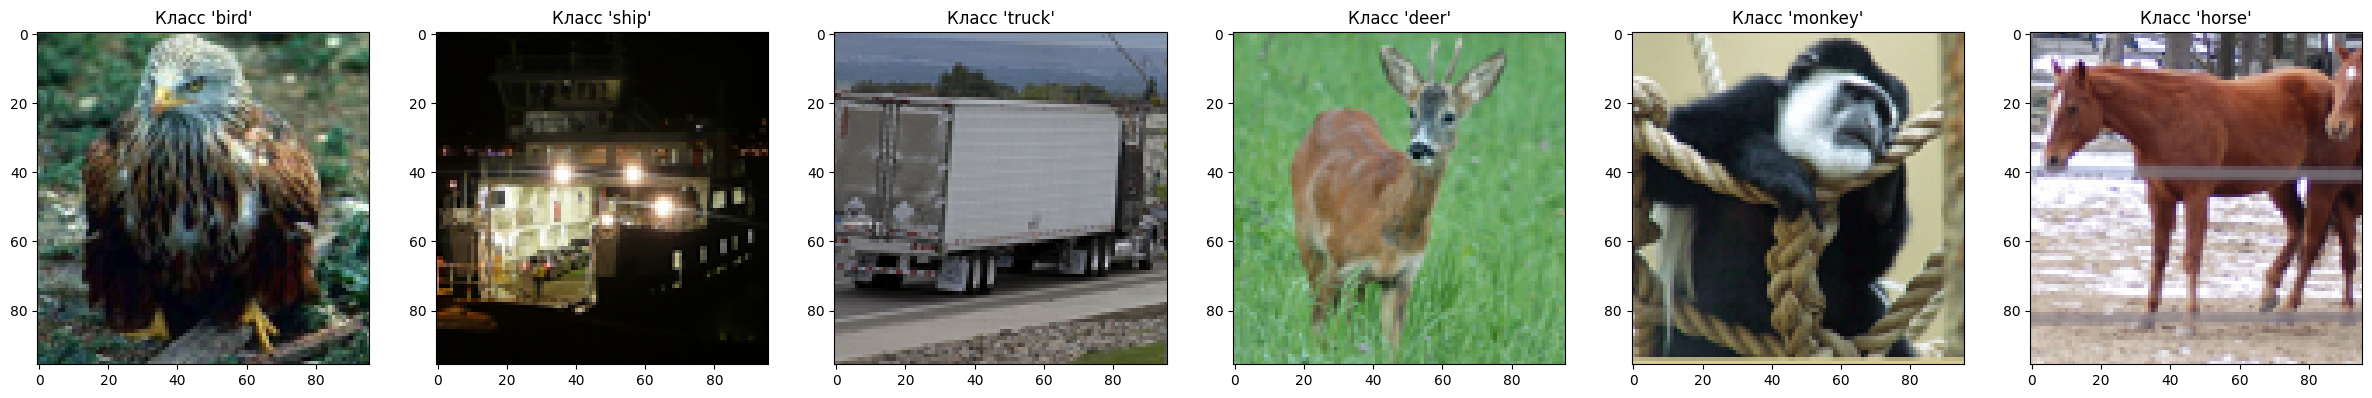

In [13]:
num_obj = 6

fig, ax = plt.subplots(1, num_obj, figsize=(30, 64))

seen_classes = set()
j = 0
for img_tensor, cl in zip(stl10_subset_X, stl10_subset_y):
    if cl not in seen_classes:
        plt.subplot(1, num_obj, j + 1)
        plt.imshow(to_pil_image(img_tensor))
        plt.title(f"Класс '{stl10_classes[cl]}'")

        seen_classes.add(cl)
        j += 1
        if j == num_obj:
            break

# Аугментации

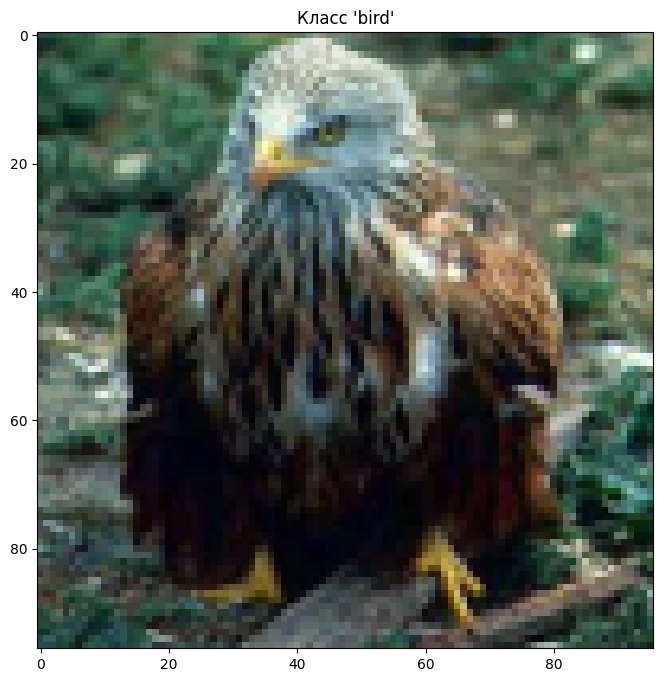

In [18]:
img, cl = to_pil_image(stl10_subset_X[0]), stl10_classes[stl10_subset_y[0]]

fig, ax = plt.subplots(figsize=(30, 8))
plt.imshow(img)
plt.title(f"Класс '{cl}'")
plt.show()

In [15]:
from torchvision import transforms

# Гарантированно отражает изображение вертикально.
vertical_flip = transforms.RandomVerticalFlip(1.)

# Гарантированно отражает изображение горизонтально.
horizontal_flip = transforms.RandomHorizontalFlip(1.)

# Гарантированно поворачивает изображение на 30 градусов по часовой стрелке.
clockwise_rotation = transforms.RandomRotation((-30, -30))

# Гарантированно поворачивает изображение на 30 градусов против часовой стрелки.
counter_clockwise_rotation = transforms.RandomRotation((30, 30))

# Уменьшает яркость.
lower_brightness = transforms.ColorJitter(brightness=(0.3, 0.3))

# Увеличивает яркость.
increase_brightness = transforms.ColorJitter(brightness=(1.7, 1.7))

# Уменьшает насыщенность.
lower_saturation = transforms.ColorJitter(saturation=(0.3, 0.3))

# Увеличивает насыщенность.
increase_saturation = transforms.ColorJitter(saturation=(4., 4.))

## Подбор аугментаций

In [39]:
img, cl = to_pil_image(stl10_subset_X[0]), stl10_classes[stl10_subset_y[0]]
needed_img = to_pil_image(torch.load('bird_transformed.pt'))

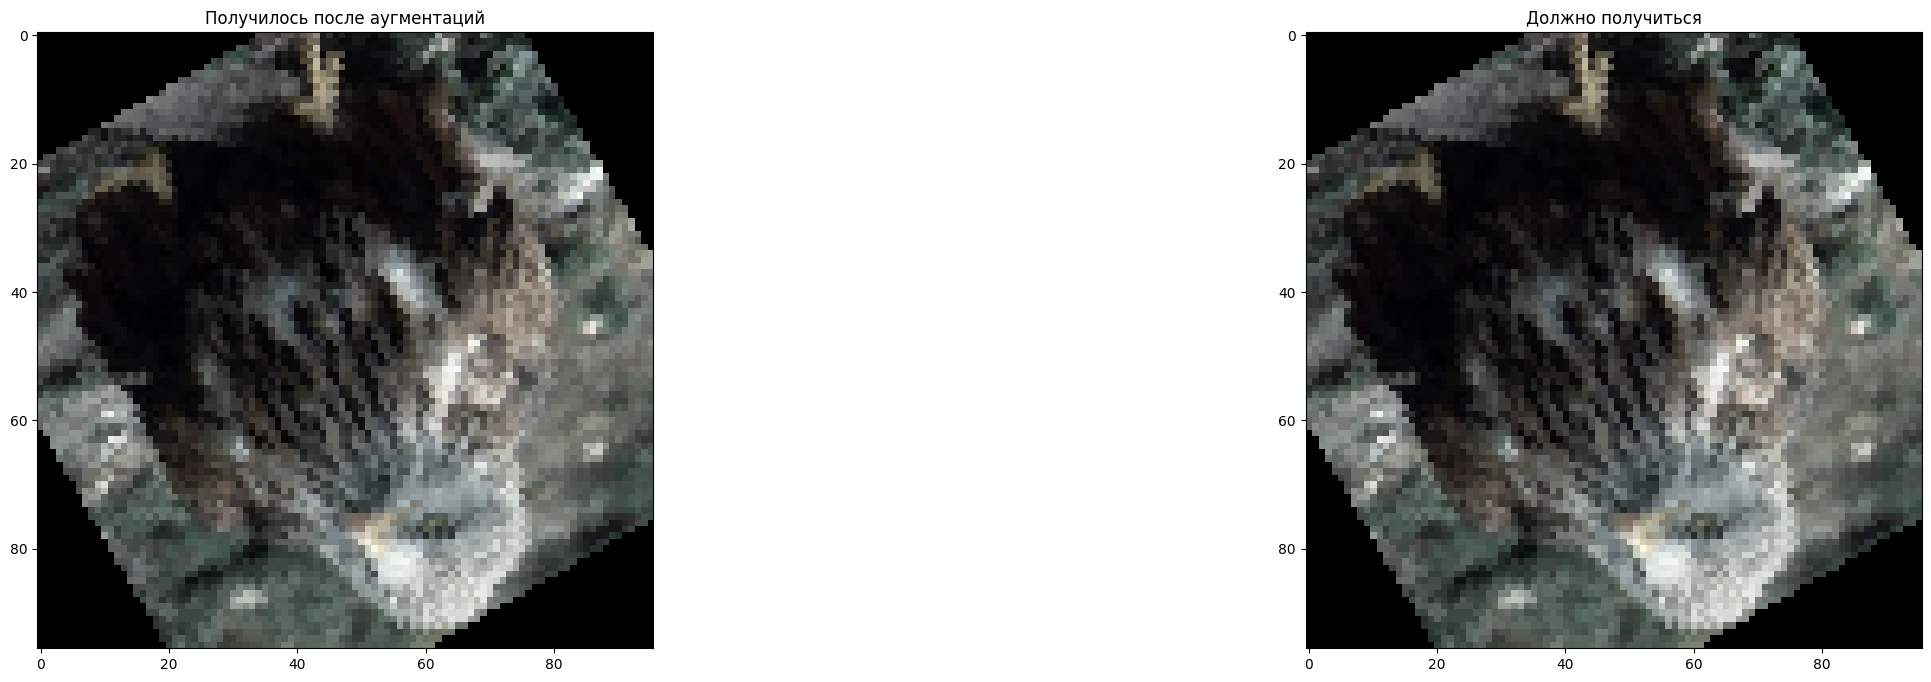

In [40]:
# Необходимо подобрать аугментации изображения и указать
# их в качестве элементов списка внутри Compose.
transforms_func = transforms.Compose([

    vertical_flip,
    counter_clockwise_rotation,
    lower_saturation


])

fig, ax = plt.subplots(1, 2, figsize=(30, 8))
plt.subplot(121)
plt.imshow(transforms_func(img))
plt.title(f"Получилось после аугментаций")
plt.subplot(122)
plt.imshow(needed_img)
plt.title("Должно получиться")
plt.show()

# Использование предобученных моделей

In [ ]:
from torchvision import models

weights = models.ResNet50_Weights.DEFAULT

In [ ]:
# Функция для преобразования входных данных — transforms.
model_transform = weights.transforms()

# TODO: Необходимо собрать модель ResNet-50 из models.resnet50,
#       подгрузив в неё веса из переменной weights.
#       По аналогии с тем, как это было в лекции.
model = None

In [ ]:
model

In [ ]:
# TODO: Необходимо преобразовать с помощью
#       model_transform значения из stl10_subset_X,
#       используя model_transform как обычную функцию.
#       Это нужно для того, чтобы привести изображения из STL-10
#       к формату, в котором с ними работает ResNet-50,
#       обученная на ImageNet.
stl10_res_subset_X = None

In [ ]:
stl10_res_subset_X.shape

In [ ]:
# Предсказание классов для изображений из STL-10 с помощью ResNet-50.
with torch.no_grad():
    pred = model(stl10_res_subset_X).max(-1).indices

## Анализ результатов

In [ ]:
with open('imagenet_classes.txt', 'r') as f:
    imagenet_classes = {}
    
    for x in f:
        ind, cls = x.strip().split(';')
        imagenet_classes[int(ind)] = cls

In [ ]:
# Ниже приведены 16 изображений из STL-10, для каждого из которых с помощью ResNet-50
# был предсказан класс в соответствии с теми классами, которые есть в ImageNet.
# У датасетов есть пересечение по классам, поэтому модель корректно
# классифицирует часть изображений из STL-10.

num_obj = 16

fig, ax = plt.subplots(4, 4, figsize=(30, 32))

seen_classes = set()
j = 0
for img_tensor, cl in zip(stl10_subset_X, pred):
    if cl not in seen_classes:
        plt.subplot(4, 4, j + 1)
        plt.imshow(to_pil_image(img_tensor))
        plt.title(f"Класс '{imagenet_classes[int(cl)]}'")

        seen_classes.add(cl)
        j += 1
        if j == num_obj:
            break

## Значение, которое нужно отправить в систему

In [ ]:
print(to_list(pred))